# TAREA DE PROGRAMACIÓN No. 1

## Computación evolutiva y optimización heurística - segundo semestre 2020
## Universidad Nacional de Colombia - Sede Medellín
### Profesora: Eddy Janneth Mesa Delgado

### Alumnos
- Edwin Fernando Villarraga Ossa
-  Santiago Giraldo Escobar

17 de Noviembre de 2020


## OBJETIVO
Utilizando una impelmentación del método de optimización Quasi-Newton de Broyden - Fletcher - Goldfard - Shanno (BFGS) en Python, se optimizarán 5 funciones para evaluar la capacidad de convergencia del método

## <span style='background:yellow'> 1. Descripción del método BFGS </span> 

El método BFGS pertenece al grupo de métodos de optimización denominados Quasi-Newton, estos métodos buscan eliminar algunas de las debilidades del método de Newton de Optimización, como son (Chandra, 2009):

1. Se elimina la necesidad de calcular la matriz Hessiana
2. Se elimina la necesidad de invertir la matriz Hessiana de segundas derivadas. Es posible que la matriz H no sea invertible.
3. El método de Newton es costoso en terminos computacionales
4. El método de Newton exige que la matriz H sea positiva definida.  La violación de este supuesto elimina la garantía de convergencia.

Por lo tanto los métodos Quasi-Newton buscan la modificación de la matriz Hessiana por una aproximación de una matriz que debe cumplir algunas condiciones como que sea definida positiva pero que es más fácil de calcular que H.


### Método de Newton

El método de Newton para encontrar raíces consiste en encontrar los puntos  $X \epsilon R^n$  tales que $\nabla f(X) = 0$

Una aproximación de segundo orden para encontrar estos puntos de forma iterativa es:

$X^{\mathrm{(k+1)}} = X^{\mathrm{(k)}}-(H_f(X^{\mathrm{(k)}}))^{\mathrm{-1}}\nabla f(X^{\mathrm{(k)}})$

Un ejemplo de la obtención de esta formula de recurrencia se puede encontrar en la página 341 de Chandra.


### Métodos "Quasi-Newton"

El método de BFGS es similar al método de Newthon pero se utiliza una aproximación de la matriz Hessiana en el punto k denominada $B_k$ y en lugar de calcular una nueva matriz $B_k$ en cada iteración, se le realiza una actualización.

$B_{k+1} = B_k + "algo"$

En el proceso iterativo es comun inicial con una matriz $B_0 = I_n$ para luego continuar con las iteraciones.  

La actualización de $B_k$ deber ser tal que se mantenga la relación:  $x_{k+1}-x_k=b_{k+1}(g_{k+1}-g_k)$ y que se mantenga definita positiva

Existen diferentes métodos de actualizar a $b_k$ y se denominan actualizaciones de rango 1 y 2 (Gramfort).




#### Fórmula de Broyden
fórmula de actualización de rango1

$B_{k+1} = B_k + \LARGE \frac{(s_k-B_ky_k)(s_k-B_ky_k)^T}{(s_k-B_ky_k)^Ty_k}$

donde:


$y_k = g_{k+1}-g_k = \nabla f(x_{k+1}) - \nabla f(x_k))$

$s_k = x_{k+1}-x_k$ 

$g_k$ es el gradiente de la función en el punto k

$y_k$ converge en menos de n iteración hacia la inversa de la Hessiana de f.  (ver prueba en Gramfort)





#### Fórmula de Davidon, Fletcher y Powell (DFP)


Es una actualización de rango 2


$B_{k+1} = B_k + \LARGE \frac{s_ks_k^T}{s_k^Ty_k} -  \frac{B_ky_ky_k^TB_k}{y_k^TB_ky_k} $


### Fórmula de Broyden-Fletcher-Goldfarb-Shanno
Es una actualización de rango 2 que se deriva de la formula DFP intercambiando los roles de $s_k$ y $y_k$

$H_{k+1} = H_k + \LARGE \frac{y_ky_k^T}{y_k^Ts_k} -  \frac{H_ks_ks_k^TH_k}{s_k^TH_ky_k} $


### Pseudo codigo para BFGS



<img src="./images/pseudo.PNG">

fuente:  Alexandre Gramfort

En el metodo DFP se actualiza la estimación de la inversa de la Hessiana. En el método BFGS se actualiza la esimación de la Hessiana.

Nocedal propone una implementación más eficiante que evita la necesidad de realizar inversión de matrices.  Se debe tener cuidado con la notación pues para Nocedal la matriz H es la inversa de la Hessiana, mientras que B es la estimación de la Hessiana (para Gramfort H representa la Hessiana y B la inversa de la Hessiana).

Para Nocenal la formula recursiva para actualizar la inversa de la matriz Hessiana estimada es:

$H_{k+1}=(I - \rho_k s_k y_k^T)H_k(I - \rho_ky_ks_k^T) + \rho_ks_kS_k^T$

donde:
$\rho_k = \frac{1}{y_k^Ts_k}$

A conitnuación se transcribe el pseudo código del libro de Nocedal

<img src="./images/pseudo1.PNG">

Las condiciones de Wolfe son:

<img src="./images/Wolfe.PNG">

que implica que el tamaño del paso debe ser tal que permita un decrecimiento en la función de manera proporcional tanto al tamaño del paso como a la dirección del gradiente, y la condición de curvatura con $C_2$ perteneciente a $(c_1,1)$



## <span style='background:yellow'> 2.  Implementación de BFGS</span> 

En primer lugar se importan las librarias necesarias para los calculos matriciales

In [1]:
import numpy as np
import numpy.linalg as ln
import scipy as sp
import scipy.optimize
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 300

Se contruye una función para las pruebas de implementación, en este caso se usará

$f(x,y) = x^2 -xy + y^2 + 9x - 6y + 20$

basado en la siguiente página:  https://sudonull.com/post/68834-BFGS-method-or-one-of-the-most-effective-optimization-methods-Python-implementation-example

y se realizarán algunas iteraciones manualmente para ilustrar el método:

Se toma como punto inicial:   $x_0 = (1,1)$

Se define un nivel de precisión para la terminación del algoritmo,gradiente mínimo:  $\epsilon = 0.001$

Se calcula el gradiente de la funcion $\nabla f = \begin{bmatrix}2x - y +9 \\-x+2y-6\end{bmatrix}$

-------


**Iteracion No. 0**
se calcula el gradiente en el punto inicial

$\nabla f = \begin{bmatrix}10\\-5\end{bmatrix}$

se evalua la condicion de terminación, con el gradiente mínimo:

$|\nabla f(x_0)| = \sqrt{10^2 + (-5)^2} = 11.18 > 0.001$

En este caso aún no se cumple la condición y se continúa con el algoritmo

Se calcula entonces la dirección de busqueda:

$p_0 = -H_0\nabla f(x_0) = - \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix} \begin{bmatrix}10\\-5\end{bmatrix} = \begin{bmatrix}-10\\5\end{bmatrix}$

en este caso se tomo como $H_0$ a la matriz identidad

se busca entonces el valor de $a_0$ para la actualización de $x_k$


$min(f(x_0 + \alpha p_0))$

$ x_0 + α_0 * p_0 = \begin{bmatrix}1\\1\end{bmatrix} + α_0 \begin{bmatrix}-10\\5\end{bmatrix}= \begin{bmatrix}1 - 10α_0\\ 1 + 5α_0\end{bmatrix} $

se evalúa la función con el parametro $\alpha_0$

$ f (α_0) = (1 - 10α_0) ^ 2 - (1 - 10α_0) (1 + 5α_0) + (1 + 5α_0) ^ 2 + 9 (1 - 10α_0) - 6 (1 + 5α_0) + 20 $

se simplifica, se deriva e iguala a cero para optener el tamaño optimo del paso

$\frac{\partial f}{\partial x} = 350 \alpha_0 - 125 = 0$   por lo tanto $\alpha_0 = 0.357$

se calcula entonces el siguiente punto:

$x_1 = x_0 + \alpha_0 p_0 = \begin{bmatrix}-2.571\\ 2.786\end{bmatrix}$

ahora se calcula $s_0$ que se requiere para la actualización de la estimación de la Hessiana

$s_0 = x_1 - x_0 = \begin{bmatrix}-2.571\\ 2.786\end{bmatrix} - \begin{bmatrix}1\\ 1\end{bmatrix} = \begin{bmatrix}-3.571\\ 1.786\end{bmatrix}$

se calcula entonces del valor de $y_0$

$y_0 = \nabla f(x_1) - \nabla f(x_0) = \begin{bmatrix}1.071\\ 2.143\end{bmatrix} - \begin{bmatrix}10\\ -5\end{bmatrix} = \begin{bmatrix}-8.929\\ 7.143\end{bmatrix}$

para finalizar la iteración 0 se calcula entonces $H_1 = \begin{bmatrix}0.694 & 0.367\\ 0.367 & 0.709\end{bmatrix}$

------


#### Definición de función y su gradiente

Se define la función para ser minimizada

In [2]:
#función a optimizar
def f(x):
    return x[0]**2 - x[0]*x[1] + x[1]**2 + 9*x[0] - 6*x[1] + 20

Se calcula el gradiente de la función $f(x)$

In [3]:
# Derivada
def f1(x):
    return np.array([2 * x[0] - x[1] + 9, -x[0] + 2*x[1] - 6])

Se define el optimizador BFGS

In [4]:
#optimizador con la implementacion de Nocedal
def bfgs_method(f, fprime, x0, maxiter=None, epsi=10e-3):
    """
    Función para minimizar la función f usando el BFGS
    Parametros
    ----------
    func : f(x)- Función que se quiere minimizar
    fprime : fprime(x) - gradiente de la función
    x0 : ndarray - Punto inicial de la búsqueda
    maxiter: int - Número máximo de iteraciones
    epsi: double - Criterio de convergencia de la norma del gradiente
    """
    if maxiter is None:
        #Se asigna un límite al numero de iteraciones propocional al numero de variables
        maxiter = len(x0) * 200
    # valores iniciales para la iteración 0
    #gfk es el gradiente de la función evaluado en x0, es un array de dos dimensiones, una por cada variable
    k = 0
    gfk = fprime(x0)
    N = len(x0)
    # Se define la matriz identidad que es la estimación inicial de la inversa de la Hessiana = Hk
    I = np.eye(N, dtype=int)
    Hk = I
    xk = x0
    #si la norma del gradiente en Xk es superior a epsilon, continua iterando y si no se ha superado el numero maximo de iteraciones
    while ln.norm(gfk) > epsi and k < maxiter:
        # pk - se calcula dirección de la búsqueda
        pk = -np.dot(Hk, gfk)
        # Se calcula la constante ak para la búsqueda lineal y que cumpla las condiciones de Wolfe
        #se usa el método line_search de la clase optimize de la libreria scipy con el alias sp
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.line_search.html
        line_search = sp.optimize.line_search(f, f1, xk, pk)
        alpha_k = line_search[0]
        # actualización de Xk a Xk+1
        xkp1 = xk + alpha_k * pk
        #se calcula sk necesario para la actualización de la Hessiana estimada
        sk = xkp1 - xk
        # se actualiza xk para la proxima iteración
        xk = xkp1
        #se calcula el gradiente en el nuevo punto xk
        gfkp1 = fprime(xkp1)
        # se calcula yk necesario para la actualización de la Hessiana estimada
        yk = gfkp1 - gfk
        # se actualiza gfk para la proxima iteración
        gfk = gfkp1
        #se actualiza la iteración
        k += 1
        # se actualiza el parametro r0
        ro = 1.0 / (np.dot(yk, sk))
        #actualización de la Hessiana inversa propuesta por Nocedal
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] *
                                                 sk[np.newaxis, :])
    return (xk, k, ln.norm(gfk), f(xk))

In [5]:
resultado, k, error, fo = bfgs_method(f, f1, np.array([1, 1]))
print('Resultado del método BFGS:')
print('Resultado final (mejor): %s' % (resultado))
print('Iteracion Número: %s' % (k))
print(f'Error en la estimación {error:.10f}')
print (f'La función objetivo en el optimo es: {fo}')

Resultado del método BFGS:
Resultado final (mejor): [-4.  1.]
Iteracion Número: 3
Error en la estimación 0.0000000000
La función objetivo en el optimo es: -1.0


 

------------------------

Usualmente las funciones complejas se optimizan usando el gradiente numérico. A continuación se muestra una implementación propia del calculo del gradiente numérico

In [6]:
#se crea una función para aproximar el gradiente numeriva en un punto - from scratch
def num_der(f, x, epsilon=0.01):
    """
    x: punto para el cual se calcula el gradiente. np.array
    """
    x = np.array(x)
    n = x.size
    gradiente = np.zeros(n)
    xp = np.copy(x)
    j=0
    for dato in x:
        xp[j] = dato + epsilon
        gradiente[j] = ((f(x) - f(xp)) / epsilon)
        j += 1
        xp = np.copy(x)
       
    return gradiente

In [7]:
#optimizador con la implementacion de Nocedal pero con gradiente numero de implementación propia
def bfgs_method_num_grad(f, fnum_grad, x0, maxiter=None, epsi=10e-3, step = 0.01):
    """
    Función para minimizar la función f usando el BFGS
    Parametros
    ----------
    func : f(x)- Función que se quiere minimizar
    fprime : fprime(x) - gradiente de la función
    x0 : ndarray - Punto inicial de la búsqueda
    maxiter: int - Número máximo de iteraciones
    epsi: double - Criterio de convergencia de la norma del gradiente
    step: tamaño del paso para la iteración de Xk
    """
    if maxiter is None:
        #Se asigna un límite al numero de iteraciones propocional al numero de variables
        maxiter = len(x0) * 500
    # valores iniciales para la iteración 0
    #gfk es el gradiente de la función evaluado en x0, es un array de dos dimensiones, una por cada variable
    k = 0
    gfk = fnum_grad(f, x0)
    N = len(x0)
    # Se define la matriz identidad que es la estimación inicial de la inversa de la Hessiana = Hk
    I = np.eye(N, dtype=int)
    Hk = I
    xk = x0
    #si la norma del gradiente en Xk es superior a epsilon, continua iterando y si no se ha superado el numero maximo de iteraciones
    while ln.norm(gfk) > epsi and k < maxiter:
        # pk - se calcula dirección de la búsqueda
        pk = -np.dot(Hk, gfk)
        # Se calcula la constante ak para la búsqueda lineal y que cumpla las condiciones de Wolfe
        #se usa el método line_search de la clase optimize de la libreria scipy con el alias sp
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.line_search.html
        #line_search = sp.optimize.line_search(f, f1, xk, pk)
        #alpha_k = line_search[0]
        # actualización de Xk a Xk+1
        alpha_k = step
        xkp1 = xk + alpha_k * pk
        #se calcula sk necesario para la actualización de la Hessiana estimada
        sk = xkp1 - xk
        # se actualiza xk para la proxima iteración
        xk = xkp1
        #se calcula el gradiente en el nuevo punto xk
        gfkp1 = fnum_grad(f, xkp1)
        # se calcula yk necesario para la actualización de la Hessiana estimada
        yk = gfkp1 - gfk
        # se actualiza gfk para la proxima iteración
        gfk = gfkp1
        #se actualiza la iteración
        k += 1
        # se actualiza el parametro r0
        ro = 1.0 / (np.dot(yk, sk))
        #actualización de la Hessiana inversa propuesta por Nocedal
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] *
                                                 sk[np.newaxis, :])
    return (xk, k, ln.norm(gfk), f(xk))

In [8]:
resultado, k, error, fo = bfgs_method_num_grad(f, num_der, np.array([1., 1.]), step=0.2)
print('Resultado del método BFGS:')
print('Resultado final (mejor): %s' % (resultado))
print('Iteracion Número: %s' % (k))
print(f'Norma del gradiente en la estimación {error:.10f}')
print (f'La función objetivo en el optimo es: {fo}')

Resultado del método BFGS:
Resultado final (mejor): [-4.00549508  0.99079957]
Iteracion Número: 37
Norma del gradiente en la estimación 0.0087093198
La función objetivo en el optimo es: -0.9999357132421629


La libreria scipy para ser usada con Python tiene implementado el método de optimizacion BFGS: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html

In [9]:
optimize.minimize(f, np.array([0.002, 0.01]), method='BFGS')

      fun: -0.9999999999999858
 hess_inv: array([[0.66687569, 0.33356236],
       [0.33356236, 0.66690562]])
      jac: array([-2.38418579e-07, -2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-4.0000001 ,  0.99999991])

Teniendo los mismos resultados que nuestra emplementación, tanto usando la gradiente analitico como el gradiente numérico

## <span style='background:yellow'> 3.  Optimización de Funciones</span> 


Para este trabajo se seleccionaron las funciones de:

- Ackley
- Esfera
- Griewank
- Rastrigin 
- Rosenbrock


Para cada funcón se desarrollan los siguientes puntos: 

- Se da explicación de la función según una fuente
- Cada función se expandira en tres dimensiones d: 2, 5 , y 10.  Y cada una de estas se optimizará para evaluar sus resultados.
- Se desarrolla una función de dos dimensiones como control y una función vectorial que permitirá desarrollar las diferentes d dimensiones pedidas en el enunciado del problema.
- Se gráfica la función de dos dimensiones en un plano cartesiano y como superficie para evaluar que el programa si corresponda a la función deseada.
- Se optimiza cada función con el método BFGS y la función derivada se aproximará con el método del gradiente, partiendo de una condición de borde como parámetros inicial para cada una de las funciones..
- Por utilizar el método del gradiente como función de aproximación de la derivada, se correra el algoritmo 25 veces para evaluar la sensibilidad de la optimización por el uso del método del gradiente.
- Se cambia la condición inicial de borde predefinida por una aleatoria.  De igual forma se corre la optimización 25 veces para evaluar la sensibilidad al método del gradiente. 

## 3.1 Función Ackley

A coninuación de muestra la definición de la función de Ackley, tomada de [www.sfu.ca](https://www.sfu.ca/~ssurjano/ackley.html)

<img src="./images/Ackley.PNG">

Los valores recomnedador para usar son:  a=20, b=0.2, c = $2\pi$ y d = numero de variables

La función usualmente es evaluada en los hiper cubos limitados por $x_i \epsilon [-32.768, 32.768]$ aunque se puede restribir a un dominio más pequeño

El mínimo global es:

$f(x^*)=0$, en $x^* = (0,...,0)$

## 3.1.1 Programación de la función de Ackley

### 3.1.1.1 Función Ackley caso 2 dimensiones expandidas manualmente

In [10]:
#Definición de la función Ackley
def f_ackley(x):
    """
    x es un array
    """
    return -20 * np.exp(-0.2*np.sqrt(0.5*(x[0]**2 + x[1]**2)))\
- np.exp(0.5*(np.cos(2*np.pi*x[0]) + np.cos(2*np.pi*x[1]))) + 20 + np.exp(1)
    

In [11]:
#ejemplo de evaluacion de la funcion Ackley en 2 dimensiones en el punto (1,1)
print (f_ackley([1,1]))

3.6253849384403627


### 3.1.1.2  Función Ackley caso de N dimensiones

In [12]:
def fN_ackley(x):
    """
    x es un array
    """
    a = 20
    b = 0.2
    c = 2*np.pi
    d = len(x)
        
    sum1 = np.sum(np.power(x,2))
    sum2 = np.sum(np.cos(c*np.power(x,2)))
    
    funcion = a + np.exp(1) - (a*np.exp(-b*np.sqrt((1/d)*sum1))) - np.exp((1/d)*sum2)
    
    return funcion    

In [13]:
print (fN_ackley([1,1]))

3.625384938440362


Se observa que el resultado para el caso N=2 es igual a la implementación para 2 dimensiones.
A continuación se realizan las gráficas de contorno y de la función

### 3.1.1.3 Gráfica de contorno de la función Ackley de dos variables en un plano cartesiano y en tres dimensiones

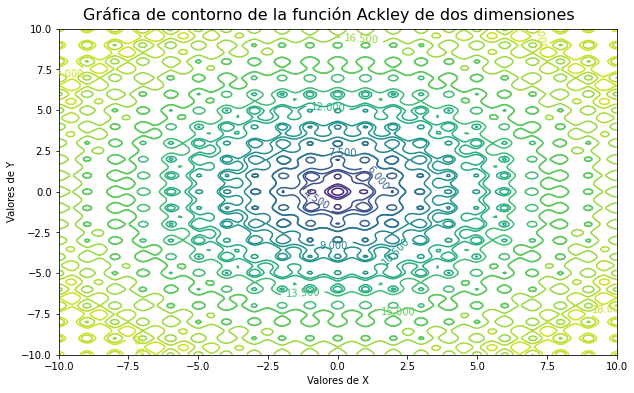

In [14]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

x = y = np.linspace(-10, 10, 200)
X,Y = np.meshgrid(x,y)
Z = f_ackley([X,Y])
cs = ax.contour(X, Y, Z, 12) #numero de niveles del contorno
ax.clabel(cs, fontsize=10) #valores de Z

#plt.title('Gráfica de contorno de la función Ackley de dos dimensiones')
plt.figtext(.5,.9,'Gráfica de contorno de la función Ackley de dos dimensiones', fontsize=16, ha='center')
plt.xlabel('Valores de X')
plt.ylabel('Valores de Y')

cs = ax.contour(X,Y,Z)
plt.show()

Text(0.5, 0.9, 'Gráfica de superficie de la función Ackley de dos dimensiones')

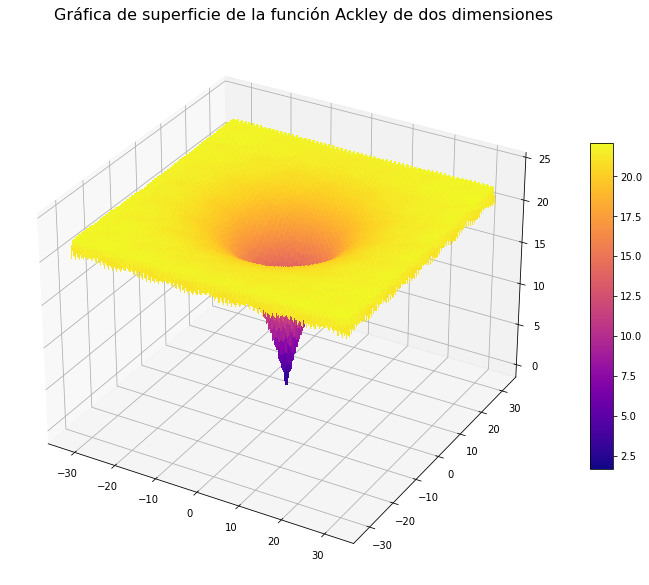

In [15]:
from matplotlib import cm

fig = plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')


x = y = np.linspace(-32, 32, 200)
X,Y = np.meshgrid(x,y)
Z = f_ackley([X,Y])
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 25.01)
fig.colorbar(surf, shrink=0.6, aspect=14)
plt.figtext(.5,.9,'Gráfica de superficie de la función Ackley de dos dimensiones', fontsize=16, ha='center')

## 3.1.2 Optimización punto de borde deterministico de la función Ackley 

### 3.1.2.1 Optimización con nuestro algoritmo de la función Ackley - punto de borde deterministico - Dimensión 2 

Para esto se usa nuestra implementación del gradiente numerico, para evitar la derivación analitica, usamos aproximación numerica.

In [16]:
#punto inicial de busqueda
ACK_X0_5_d = np.array([-30.,30.,7., 6., 4.]) #la dimension está implicita en el tamaño del vector Xo inicial

In [17]:
#optimización con nuestro optimizador
resultado, k, error, fo = bfgs_method_num_grad(fN_ackley, num_der, ACK_X0_5_d, maxiter=None, epsi=10e-3, step=.6)

print('Resultado del método BFGS:')
print('Resultado final (mejor): %s' % (resultado))
print('Iteracion Número: %s' % (k))
print(f'Norma del gradiente en la estimación {error:.10f}')
print (f'La función objetivo en el optimo es: {fo}')

Resultado del método BFGS:
Resultado final (mejor): [-423.3553277   402.13241433 1365.73838731  763.92955218 1025.16498589]
Iteracion Número: 144
Norma del gradiente en la estimación 0.0052885759
La función objetivo en el optimo es: 22.08370569775686


La siguiente instrucción evalua la función de Ackley con la libreria scipy, empleando el método predefinido BFGS

In [18]:
optimize.minimize(fN_ackley,  ACK_X0_5_d, method='BFGS')

      fun: 19.595057929596397
 hess_inv: array([[ 1.29404754e-05, -1.74907161e-09,  1.81674238e-08,
         3.27422151e-08,  1.31698805e-08],
       [-1.74907158e-09,  1.29408867e-05,  1.75173696e-08,
         3.06544523e-08,  1.25295638e-08],
       [ 1.81674238e-08,  1.75173696e-08,  2.37737446e-04,
        -3.06745382e-08,  2.04428974e-08],
       [ 3.27422151e-08,  3.06544523e-08, -3.06745383e-08,
         3.23667447e-04, -1.61775250e-07],
       [ 1.31698805e-08,  1.25295636e-08,  2.04428973e-08,
        -1.61775250e-07,  7.28227074e-04]])
      jac: array([-1.19209290e-06, -1.19209290e-06,  0.00000000e+00,  2.38418579e-07,
        0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 77
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([-29.99999968,  29.99999967,   6.99999861,   5.99999838,
         3.99999757])

Nuestro optimizador requirió aumentar el tamaño de los pasos para la actualización de Xk para evitar lo optimos locales.

Se ejecutará 25 veces nuestro optimizador iniciando en el mismo punto $X_0$

In [19]:
# Este evaluador hace 25 corridas del mismo proceso para evaluar si hay sensibilidad en los gradientes 
def evaluador(funcion, X0, paso=0.1 , corridas= 25):
    """
    funcion:  es la funcion a optimizar - bfgs_method_num_grad(fN_ackley, num_der, X_inicial, maxiter=None, epsi=10e-3, step=.6)
    x0: vector de inicio
    
    """
    n = len(X0)
    f_resultados = list()
    x_resultados = list()
    ng_resultados = list()
    k_resultados = list()
    
    for corrida in range(corridas):
        #print (sensibilidad)
        resultado, k, ng, fo = bfgs_method_num_grad(funcion, num_der, X0, maxiter=None, epsi=10e-3, step= paso)
        #print (resultado)
        #print (fo)
        f_resultados.append(fo)
        x_resultados.append(resultado)
        ng_resultados.append(ng)
        k_resultados.append(k)
        
    promedio = np.nanmean(np.array(f_resultados))     
    maximo = np.nanmax(np.array(f_resultados)) 
    minimo = np.nanmin(np.array(f_resultados)) 
    mediana = np.nanmedian(np.array(f_resultados)) 
    
    resultados_dict = {"Paso": paso, "Iteraciones para convergencia":k_resultados, "gradiente en el minimo":ng_resultados, "F(X) en el minimo":f_resultados, "Coordenadas":x_resultados}
    
    resultados_df = pd.DataFrame(resultados_dict)
        
    return minimo, maximo, promedio, mediana, resultados_df

In [20]:
ACK_X0_2 = [16.,16]
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()
#type(var_sensibilidad)
#print (var_sensibilidad)

In [21]:
Ackley2_min, Ackley2_max, Ackley2_prom, Ackley2_med, Ackley2_datos = evaluador(fN_ackley, ACK_X0_2, 0.6, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Ackley2_min}")
print ("El minimo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Ackley2_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Ackley2_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Ackley2_med}"))
Ackley2_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 20.00387710689607
El minimo de los minimo valor de la función en las 25 optimizaciones es: 20.00387710689607
El promedio de los minimos de la función en las 25 optimizaciones es: 20.00387710689607
La mediana del minimo del valor de la función en las 25 optimizaciones es: 20.00387710689607


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
1,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
2,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
3,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
4,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
5,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
6,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
7,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
8,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"
9,0.6,14,0.004124,20.003877,"[99.14135617665386, 99.14135617665386]"


### 3.1.2.2 Optimización con nuestro algoritmo dela función Ackley - punto de borde deterministico  - Dimensión 5

In [22]:
ACK_X0_5 = [-12.,12, -12, 12, -12]
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [23]:
Ackley5_min, Ackley5_max, Ackley5_prom, Ackley5_med, Ackley5_datos = evaluador(fN_ackley, ACK_X0_5, 0.6, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Ackley5_min}")
print ("El minimo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Ackley5_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Ackley5_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Ackley5_med}"))
Ackley5_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 22.23282372560732
El minimo de los minimo valor de la función en las 25 optimizaciones es: 22.23282372560732
El promedio de los minimos de la función en las 25 optimizaciones es: 22.23282372560732
La mediana del minimo del valor de la función en las 25 optimizaciones es: 22.23282372560732


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
1,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
2,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
3,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
4,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
5,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
6,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
7,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
8,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"
9,0.6,78,0.005431,22.232824,"[516.6104275304674, 1050.7242705466574, 554.8147905773787, 1365.5143151058005, 564.8294890226471]"


Se calcula la media, minimo, maximo y mediana, ignorando los errores de convergencia.

### 3.1.2.3 Optimización con nuestro algoritmo de la función Ackley - punto de borde deterministico  - Dimensión 10

In [24]:
ACK_X0_10 = [-12.,12, -12, 12, -12, 16, -12, 12, -12, 9]
# var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [25]:
Ackley10_min, Ackley10_max, Ackley10_prom, Ackley10_med, Ackley10_datos = evaluador(fN_ackley, ACK_X0_10, 0.6, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Ackley10_min}")
print ("El minimo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Ackley10_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Ackley10_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Ackley10_med}"))
Ackley10_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 21.87718847946777
El minimo de los minimo valor de la función en las 25 optimizaciones es: 21.87718847946777
El promedio de los minimos de la función en las 25 optimizaciones es: 21.87718847946777
La mediana del minimo del valor de la función en las 25 optimizaciones es: 21.87718847946777


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
1,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
2,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
3,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
4,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
5,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
6,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
7,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
8,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"
9,0.6,365,0.009088,21.877188,"[-2811.159478130648, -3081.4574172733433, -1946.1731582082557, 3280.827516288671, 2241.388874348183, -2657.0648412499468, 2958.1549010109206, 510.67053296384023, 2101.7291649308168, 2525.0748997289443]"


## 3.1.3  Caso con puntos de inicio aleatorios de la función Ackley

In [26]:
# Parametrización de la semilla para reproducibilidad en los datos.  La semilla aplica para todos las
# funciones en donde se utlice un número aleatorio en este notebook
np.random.seed(seed=1)

### 3.1.3.1 Optimización con nuestro algoritmo de la función Ackley - puntos de inicio aleatorios - Dimensión 2

In [27]:
ACK_X0_2A = np.random.uniform(low=-16, high=16, size=2)
ACK_X0_2A

array([-2.65529585,  7.05038379])

In [28]:
#caso de dos dimensions, inicio aleatorio

Ackley2A_min, Ackley2A_max, Ackley2A_prom, Ackley2A_med, Ackley2A_datos = evaluador(fN_ackley, ACK_X0_2A,  0.6, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Ackley2A_min}")
print ("El minimo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Ackley2A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Ackley2A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Ackley2A_med}"))
Ackley2A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 22.267431395999797
El minimo de los minimo valor de la función en las 25 optimizaciones es: 22.267431395999797
El promedio de los minimos de la función en las 25 optimizaciones es: 22.267431395999797
La mediana del minimo del valor de la función en las 25 optimizaciones es: 22.267431395999797


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
1,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
2,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
3,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
4,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
5,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
6,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
7,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
8,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"
9,0.6,25,0.004,22.267431,"[9.508146543746049, 60.715671878777265]"


### 3.1.3.2 Optimización con nuestro algoritmo de la función Ackley - puntos de inicio aleatorios - Dimensión 5

In [29]:
ACK_X0_5A = np.random.uniform(low=-16, high=16, size=5)
ACK_X0_5A

array([-15.99634001,  -6.32535768, -11.30381149, -13.04516497,
       -10.03967324])

In [30]:
Ackley5A_min, Ackley5A_max, Ackley5A_prom, Ackley5A_med, Ackley5A_datos = evaluador(fN_ackley, ACK_X0_5A,  0.6, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Ackley5A_min}")
print ("El minimo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Ackley5A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Ackley5A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Ackley5A_med}"))
Ackley5A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 21.916351432252487
El minimo de los minimo valor de la función en las 25 optimizaciones es: 21.916351432252487
El promedio de los minimos de la función en las 25 optimizaciones es: 21.916351432252487
La mediana del minimo del valor de la función en las 25 optimizaciones es: 21.916351432252487


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
1,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
2,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
3,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
4,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
5,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
6,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
7,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
8,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"
9,0.6,225,0.007127,21.916351,"[84.00392801626454, 193.77193360073073, -256.9884623144417, 343.44659768686364, 18.99499960985001]"


### 3.1.2.5.3 Optimización con nuestro algoritmo de la función Ackley - puntos de inicio aleatorios - Dimensión 10

In [31]:
ACK_X0_10A = np.random.uniform(low=-16, high=16, size=10)
ACK_X0_10A

array([ -4.94205673,  -3.30344082,   1.24213549,  -2.58577554,
         5.92702401,  -9.45752801,  12.09975796, -15.12359702,
         5.45496033,  -2.64624632])

In [32]:
Ackley10A_min, Ackley10A_max, Ackley10A_prom, Ackley10A_med, Ackley10A_datos = evaluador(fN_ackley, ACK_X0_10A, 0.6, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Ackley10A_min}")
print ("El minimo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Ackley10A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Ackley10A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Ackley10A_med}"))
Ackley10A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 21.92234974316395
El minimo de los minimo valor de la función en las 25 optimizaciones es: 21.92234974316395
El promedio de los minimos de la función en las 25 optimizaciones es: 21.92234974316395
La mediana del minimo del valor de la función en las 25 optimizaciones es: 21.92234974316395


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
1,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
2,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
3,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
4,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
5,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
6,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
7,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
8,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"
9,0.6,468,0.005181,21.92235,"[-4860.551677068406, -5479.315723074952, -458.17200007792655, -2008.8137265947473, 7527.750342728011, 1007.0374519163216, 7356.113779624709, -328.8050911964944, -3929.421178003674, -1661.6066369676257]"


## 3.2 Función Esfera

Función tomada de la página [www.sfu.ca](https://www.sfu.ca/~ssurjano/spheref.html)

<img src="https://www.sfu.ca/~ssurjano/spheref.png">

<img src="https://www.sfu.ca/~ssurjano/spheref2.png">

Es una función continua y convexa y usalmente se evalua en el intervalo $[-5.12, 5.12]$

La función esfera tiene el mínimo global en el punto $f(x^*) = 0$ en $x^* \epsilon [0,...,0]$

## 3.2.1 Programación de la función Esfera

### 3.2.1.1 Función Esfera caso 2 dimensiones expandidas manualmente

In [33]:
# Definición de la función Ackley
def f_esfera(x):
    """
    x es un array
    """
    return np.power(x[0],2) +np.power(x[1],2)

In [34]:
# Ejemplo de evaluacion de la funcion esfera en 2 dimensiones en el punto (1,1)
print (f_esfera([1,1]))

2


### 3.2.1.2  Función Esfera caso de N dimensiones

In [35]:
def fN_esfera(x):
    """
    x es un array
    """
    funcion = np.sum(np.power(x,2))
    
    return funcion  

In [36]:
print (fN_esfera([1,1]))

2


Se observa que el resultado para el caso N=2 es igual a la implementación para 2 dimensiones. A continuación se realizan las gráficas de contorno y de la función

### 3.2.1.3 Gráfica de contorno de la función Esfera de dos variables en un plano cartesiano y en tres dimensiones

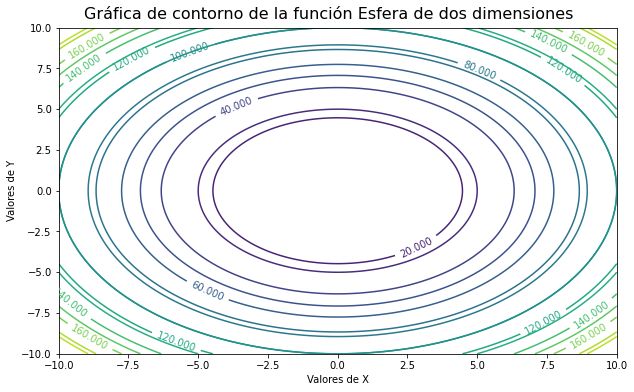

In [37]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

x = y = np.linspace(-10, 10, 200)
X,Y = np.meshgrid(x,y)
Z = f_esfera([X,Y])
cs = ax.contour(X, Y, Z, 12) #numero de niveles del contorno
ax.clabel(cs, fontsize=10) #valores de Z

#plt.title('Gráfica de contorno de la función Ackley de dos dimensiones')
plt.figtext(.5,.9,'Gráfica de contorno de la función Esfera de dos dimensiones', fontsize=16, ha='center')
plt.xlabel('Valores de X')
plt.ylabel('Valores de Y')

cs = ax.contour(X,Y,Z)
plt.show()

Text(0.5, 0.9, 'Gráfica de superficie de la función Esfera de dos dimensiones')

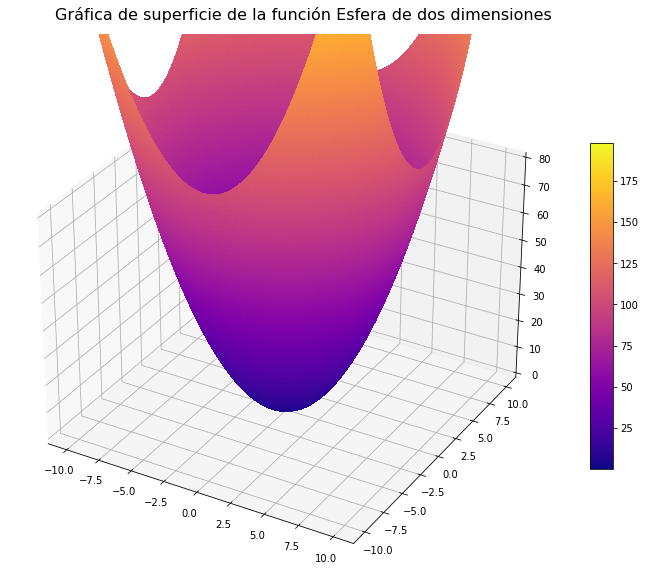

In [38]:
from matplotlib import cm

fig = plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')


x = y = np.linspace(-10, 10, 200)
X,Y = np.meshgrid(x,y)
Z = f_esfera([X,Y])
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 80)
fig.colorbar(surf, shrink=0.6, aspect=14)
plt.figtext(.5,.9,'Gráfica de superficie de la función Esfera de dos dimensiones', fontsize=16, ha='center')

## 3.2.2 Optimización punto de borde deterministico de la función Esfera 

### 3.2.2.1 Optimización con nuestro algoritmo de la función Esfera - punto de borde deterministico - Dimensión 2 

In [39]:
ESF_X0_2 = [5.,5]
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [40]:
Esfera2_min, Esfera2_max, Esfera2_prom, Esfera2_med, Esfera2_datos = evaluador(fN_esfera, ESF_X0_2 , 1, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Esfera2_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Esfera2_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Esfera2_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Esfera2_med}"))
Esfera2_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 4.999999999763532e-05
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 4.999999999763532e-05
El promedio de los minimos de la función en las 25 optimizaciones es: 4.999999999763531e-05
La mediana del minimo del valor de la función en las 25 optimizaciones es: 4.999999999763532e-05


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
1,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
2,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
3,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
4,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
5,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
6,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
7,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
8,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"
9,1,2,3.344170e-13,0.00005,"[-0.004999999999881766, -0.004999999999881766]"


### 3.2.2..2 Optimización con nuestro algoritmo dela función Esfera - punto de borde deterministico  - Dimensión 5

In [41]:
ESF_X0_5 = [5.,5., 5., 5., 5.]
# var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [42]:
Esfera5_min, Esfera5_max, Esfera5_prom, Esfera5_med, Esfera5_datos = evaluador(fN_esfera, ESF_X0_5 , 1, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Esfera5_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Esfera5_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Esfera5_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Esfera5_med}"))
Esfera5_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 0.00012500000013616132
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 0.00012500000013616132
El promedio de los minimos de la función en las 25 optimizaciones es: 0.00012500000013616132
La mediana del minimo del valor de la función en las 25 optimizaciones es: 0.00012500000013616132


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
1,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
2,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
3,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
4,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
5,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
6,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
7,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
8,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"
9,1,2,1.217864e-11,0.000125,"[-0.005000000002720384, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937, -0.005000000002723937]"


### 3.2.2.3 Optimización con nuestro algoritmo de la función Esfera - punto de borde deterministico  - Dimensión 10

In [43]:
ESF_X0_10 = [5.,5., 5., 5., 5., 5., 5., 5., 5., 5.]
var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [44]:
Esfera10_min, Esfera10_max, Esfera10_prom, Esfera10_med, Esfera10_datos = evaluador(fN_esfera, ESF_X0_10 , 1, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Esfera10_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Esfera10_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Esfera10_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Esfera10_med}"))
Esfera10_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 0.000250000000272145
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 0.000250000000272145
El promedio de los minimos de la función en las 25 optimizaciones es: 0.00025000000027214505
La mediana del minimo del valor de la función en las 25 optimizaciones es: 0.000250000000272145


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
1,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
2,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
3,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
4,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
5,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
6,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
7,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
8,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"
9,1,2,1.721197e-11,0.00025,"[-0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.005000000002720384, -0.00500000000272216, -0.005000000002725713, -0.005000000002723937, -0.005000000002720384, -0.005000000002720384]"


## 3.2.3  Caso con puntos de inicio aleatorios de la función Esfera

### 3.2.3.1 Optimización con nuestro algoritmo de la función Esfera - puntos de inicio aleatorios - Dimensión 2

In [45]:
ESF_X0_2A = np.random.uniform(low=-5, high=5, size=2)
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [46]:
Esfera2A_min, Esfera2A_max, Esfera2A_prom, Esfera2A_med, Esfera2A_datos = evaluador(fN_esfera, ESF_X0_2A , 1, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Esfera2A_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Esfera2A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Esfera2A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Esfera2A_med}"))
Esfera2A_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 5.000000000714771e-05
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 5.000000000714771e-05
El promedio de los minimos de la función en las 25 optimizaciones es: 5.000000000714771e-05
La mediana del minimo del valor de la función en las 25 optimizaciones es: 5.000000000714771e-05


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
1,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
2,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
3,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
4,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
5,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
6,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
7,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
8,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"
9,1,2,1.121645e-12,0.00005,"[-0.005000000000529248, -0.005000000000185523]"


### 3.2.3.2 Optimización con nuestro algoritmo de la función Esfera - puntos de inicio aleatorios - Dimensión 5

In [47]:
ESF_X0_5A = np.random.uniform(low=-5, high=5, size=5)

In [48]:
Esfera5A_min, Esfera5A_max, Esfera5A_prom, Esfera5A_med, Esfera5A_datos = evaluador(fN_esfera, ESF_X0_5A , 1, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Esfera5A_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Esfera5A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Esfera5A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Esfera5A_med}"))
Esfera5A_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 0.00012499999998027712
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 0.00012499999998027712
El promedio de los minimos de la función en las 25 optimizaciones es: 0.00012499999998027712
La mediana del minimo del valor de la función en las 25 optimizaciones es: 0.00012499999998027712


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
1,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
2,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
3,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
4,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
5,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
6,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
7,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
8,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"
9,1,2,5.014992e-12,0.000125,"[-0.0049999999988852295, -0.00499999999976275, -0.004999999999569127, -0.005000000001452065, -0.00499999999835854]"


### 3.2.3.3 Optimización con nuestro algoritmo de la función Esfera - puntos de inicio aleatorios - Dimensión 10

In [49]:
ESF_X0_10A = np.random.uniform(low=-5, high=5, size=10)

In [50]:
Esfera10A_min, Esfera10A_max, Esfera10A_prom, Esfera10A_med, Esfera10A_datos = evaluador(fN_esfera, ESF_X0_10A , 1, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Esfera10A_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Esfera10A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Esfera10A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Esfera10A_med}"))
Esfera10A_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 0.0002499999998724336
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 0.0002499999998724336
El promedio de los minimos de la función en las 25 optimizaciones es: 0.0002499999998724336
La mediana del minimo del valor de la función en las 25 optimizaciones es: 0.0002499999998724336


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
1,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
2,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
3,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
4,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
5,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
6,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
7,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
8,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"
9,1,2,3.087111e-11,0.00025,"[-0.00499999999444789, -0.004999999994851123, -0.004999999993859916, -0.004999999994586446, -0.004999999999768079, -0.0049999999975511855, -0.0050000000065413275, -0.005000000003363425, -0.004999999996078586, -0.005000000006195382]"


## 3.3 Función Griewank

Función tomada de la página [www.sfu.ca](https://www.sfu.ca/~ssurjano/griewank.html)

<img src="https://www.sfu.ca/~ssurjano/griewank.png">

<img src="https://www.sfu.ca/~ssurjano/griewank2.png">

Es una función continua que tiene muchos mínimos locales que están distribuisoa de forma regular. 

Esta función usulmente se evalua en el hipercubo $x_i$ perteneciente a $[-600, 600]$

La función Griewank tiene el mínimo global en el punto $f(x^*) = 0$ en $x^* \epsilon [0,...,0]$

## 3.3.1 Programación de la función Griewank

### 3.3.1.1 Función Griewank caso 2 dimensiones expandidas manualmente

In [51]:
# Definición de la función
def f_griewank(x):
    """
    x es un array
    """
    return (((x[0]**2) + (x[1]**2))/4000) - (np.cos(x[0]/np.sqrt(2)))*(np.cos(x[1]/np.sqrt(2))) + 1

In [52]:
# Ejemplo de evaluacion de la funcion Griewank en 2 dimensiones en el punto (1,1)
print (f_griewank([1.,1.]))

0.4225281526173127


### 3.3.1.2  Función Griewankcaso de N dimensiones

In [53]:
def fN_griewank(x):
    """
    x es un array
    """
    n = len(x)
    suma1 = (np.sum(np.power(x,2)))/4000
    prod2 = np.prod(np.cos(x / np.sqrt(n)))
    funcion = suma1 - prod2 + 1
    
    return funcion  

In [54]:
print (fN_griewank([1,1]))

0.4225281526173127


Se observa que el resultado para el caso N=2 es igual a la implementación para 2 dimensiones. A continuación se realizan las gráficas de contorno y de la función

### 3.3.1.3 Gráfica de contorno de la función Griewank de dos variables en un plano cartesiano y en tres dimensiones

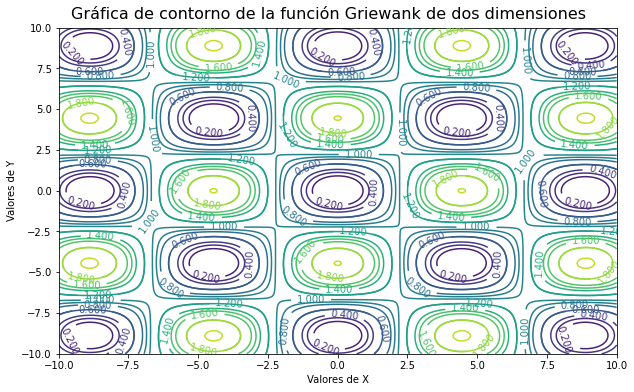

In [55]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

x = y = np.linspace(-10, 10, 200)
X,Y = np.meshgrid(x,y)
Z = f_griewank([X,Y])
cs = ax.contour(X, Y, Z, 12) #numero de niveles del contorno
ax.clabel(cs, fontsize=10) #valores de Z

#plt.title('Gráfica de contorno de la función Griewank de dos dimensiones')
plt.figtext(.5,.9,'Gráfica de contorno de la función Griewank de dos dimensiones', fontsize=16, ha='center')
plt.xlabel('Valores de X')
plt.ylabel('Valores de Y')

cs = ax.contour(X,Y,Z)
plt.show()

Text(0.5, 0.9, 'Gráfica de superficie de la función Griewank de dos dimensiones')

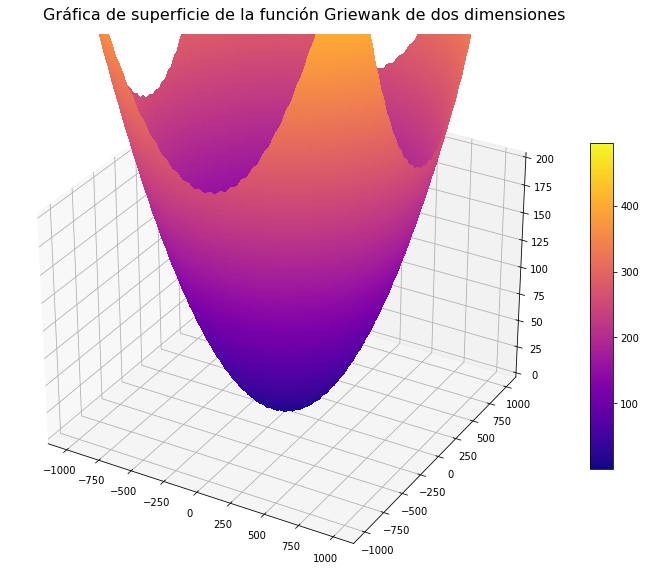

In [56]:
from matplotlib import cm

fig = plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')


x = y = np.linspace(-1000, 1000, 200)
X,Y = np.meshgrid(x,y)
Z = f_griewank([X,Y])
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 200)
fig.colorbar(surf, shrink=0.6, aspect=14)
plt.figtext(.5,.9,'Gráfica de superficie de la función Griewank de dos dimensiones', fontsize=16, ha='center')

Text(0.5, 0.9, 'Gráfica de superficie de la función griewank de dos dimensiones evaluada en un rango más pequeño')

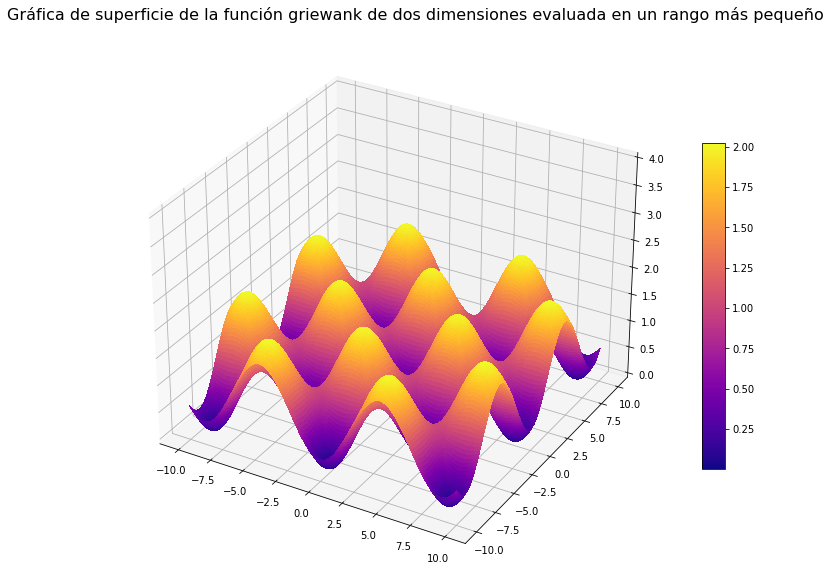

In [57]:
from matplotlib import cm

fig = plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')


x = y = np.linspace(-10, 10, 200)
X,Y = np.meshgrid(x,y)
Z = f_griewank([X,Y])
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 4)
fig.colorbar(surf, shrink=0.6, aspect=14)
plt.figtext(.5,.9,'Gráfica de superficie de la función griewank de dos dimensiones evaluada en un rango más pequeño', fontsize=16, ha='center')

## 3.3.2 Optimización punto de borde deterministico de la función Griewank

### 3.3.2.1 Optimización con nuestro algoritmo de la función Griewank - punto de borde deterministico - Dimensión 2 

In [58]:
GRI_X0_2 = [100.,100]
#var_sensibilidad  = np.around(np.linspace(0.01, 2, num=25, endpoint=True), decimals=3).tolist()

In [59]:
Griewank2_min, Griewank2_max, Griewank2_prom, Griewank2_med, Griewank2_datos = evaluador(fN_griewank, GRI_X0_2, 1.005, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Griewank2_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Griewank2_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Griewank2_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Griewank2_med}"))
Griewank2_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 6.001497121526553
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 6.001497121526553
El promedio de los minimos de la función en las 25 optimizaciones es: 6.001497121526552
La mediana del minimo del valor de la función en las 25 optimizaciones es: 6.001497121526553


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
1,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
2,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
3,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
4,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
5,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
6,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
7,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
8,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"
9,1.005,2,0.000009,6.001497,"[100.06531213725205, 100.06531213725205]"


### 3.3.2..2 Optimización con nuestro algoritmo dela función Griewank- punto de borde deterministico  - Dimensión 5

In [60]:
GRI_X0_5 = [100.,100., 100., 100., 100.]
#var_sensibilidad  = np.around(np.linspace(0.01, 2, num=25, endpoint=True), decimals=3).tolist()

In [61]:
Griewank5_min, Griewank5_max, Griewank5_prom, Griewank5_med, Griewank5_datos = evaluador(fN_griewank, GRI_X0_5, 1.005, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Griewank5_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Griewank5_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Griewank5_prom))
print (f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Griewank5_med}")
Griewank5_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 5.030161844756077
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 5.030161844756077
El promedio de los minimos de la función en las 25 optimizaciones es: 5.030161844756077
La mediana del minimo del valor de la función en las 25 optimizaciones es: 5.030161844756077


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
1,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
2,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
3,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
4,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
5,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
6,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
7,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
8,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"
9,1.005,18,0.000796,5.030162,"[49.29453147025415, 49.29453147025416, 49.29453147025394, 49.29453147025404, 49.294531470253894]"


### 3.3.2.3 Optimización con nuestro algoritmo de la función Griewank - punto de borde deterministico  - Dimensión 10

In [62]:
GRI_X0_10 = [100.,100., 100., 100., 100., 100., 100., 100., 100., 100.]
#var_sensibilidad  = np.around(np.linspace(0.01, 2, num=25, endpoint=True), decimals=3).tolist()

In [63]:
Griewank10_min, Griewank10_max, Griewank10_prom, Griewank10_med, Griewank10_datos = evaluador(fN_griewank, GRI_X0_10, 1.005, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Griewank10_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Griewank10_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Griewank10_prom))
print (f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Griewank10_med}")
Griewank10_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 24.624073437424585
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 24.624073437424585
El promedio de los minimos de la función en las 25 optimizaciones es: 24.624073437424585
La mediana del minimo del valor de la función en las 25 optimizaciones es: 24.624073437424585


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
1,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
2,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
3,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
4,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
5,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
6,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
7,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
8,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"
9,1.005,4,0.004769,24.624073,"[97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348043605, 97.85047348044306, 97.85047348044306]"


## 3.3.3  Caso con puntos de inicio aleatorios de la función Griewank

### 3.3.3.1 Optimización con nuestro algoritmo de la función Griewank - puntos de inicio aleatorios - Dimensión 2

In [64]:
GRI_X0_2A = np.random.uniform(low=-100, high=100, size=2)
GRI_X0_2A

array([ 38.37542279, -36.8968738 ])

In [65]:
Griewank2A_min, Griewank2A_max, Griewank2A_prom, Griewank2A_med, Griewank2A_datos = evaluador(fN_griewank, GRI_X0_2A, 1.005, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Griewank2A_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Griewank2A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Griewank2A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Griewank2A_med}"))
Griewank2A_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 1.7236492264735328
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 1.7236492264735328
El promedio de los minimos de la función en las 25 optimizaciones es: 1.7236492264735326
La mediana del minimo del valor de la función en las 25 optimizaciones es: 1.7236492264735328


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
1,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
2,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
3,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
4,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
5,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
6,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
7,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
8,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"
9,1.005,9,0.002053,1.723649,"[42.242623346056426, -33.36755935289324]"


### 3.3.3.2 Optimización con nuestro algoritmo de la función Griewank - puntos de inicio aleatorios - Dimensión 5

In [66]:
GRI_X0_5A = np.random.uniform(low=-100, high=100, size=5)
GRI_X0_5A

array([ 37.30018554,  66.92513438, -96.34234453,  50.02886299,
        97.77221778])

In [67]:
Griewank5A_min, Griewank5A_max, Griewank5A_prom, Griewank5A_med, Griewank5A_datos = evaluador(fN_griewank, GRI_X0_5A, 1.005, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Griewank5A_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Griewank5A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Griewank5A_prom))
print (f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Griewank5A_med}")
Griewank5A_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 2.067494480466931
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 2.067494480466931
El promedio de los minimos de la función en las 25 optimizaciones es: 2.067494480466931
La mediana del minimo del valor de la función en las 25 optimizaciones es: 2.067494480466931


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
1,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
2,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
3,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
4,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
5,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
6,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
7,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
8,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"
9,1.005,46,0.003421,2.067494,"[6.9901119107108105, 49.04670512701642, -42.05422943725685, 6.995998450833104, 63.06863827213403]"


### 3.3.3.3 Optimización con nuestro algoritmo de la función Griewank - puntos de inicio aleatorios - Dimensión 10

In [68]:
GRI_X0_10A = np.random.uniform(low=-100, high=100, size=10)
GRI_X0_10A

array([ 49.63313088, -43.91120159,  57.85586569, -79.35479868,
       -10.42129476,  81.71910062, -41.27717033, -42.44493228,
       -73.99428558, -96.12660843])

In [69]:
Griewank10A_min, Griewank10A_max, Griewank10A_prom, Griewank10A_med, Griewank10A_datos = evaluador(fN_griewank, GRI_X0_10A, 1.005, 25)
print (f"El minimo de los minimos del valor de la función en las 25 optimizaciones es: {Griewank10A_min}")
print ("El minimo de los minimos del valor de la función en las 25 optimizaciones es: {}".format(Griewank10A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Griewank10A_prom))
print (f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Griewank10A_med}")
Griewank10A_datos

El minimo de los minimos del valor de la función en las 25 optimizaciones es: 1.0772680060091544
El minimo de los minimos del valor de la función en las 25 optimizaciones es: 1.0772680060091544
El promedio de los minimos de la función en las 25 optimizaciones es: 1.0772680060091546
La mediana del minimo del valor de la función en las 25 optimizaciones es: 1.0772680060091544


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
1,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
2,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
3,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
4,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
5,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
6,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
7,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
8,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"
9,1.005,62,0.00914,1.077268,"[5.476326102818042, -8.548809307912773, -0.26031329098658773, -3.6003706729469656, -0.6356374213493132, 4.284008764512322, -1.3245985682824486, -4.444218156708646, -12.076974700470785, -1.1212256510743828]"


## 3.4 Función Rastrigin

Función tomada de la página [www.sfu.ca](http://www.sfu.ca/~ssurjano/rastr.html)

<img src="http://www.sfu.ca/~ssurjano/rastr.png">
<img src="http://www.sfu.ca/~ssurjano/rastr2.png">

Es una función continua semiconvexa y usualmente se evalua en el hipercubo $x_i$ ∈ $[-5.12, 5.12]$, para todo i = 1, …, d.

La función Rastrigin tiene el mínimo global en el punto $f(x^*) = 0$ en $x^* \epsilon [0,...,0]$

## 3.4.1 Programación de la función Rastrigin

### 3.4.1.1 Función Rastrigin caso 2 dimensiones expandidas manualmente

In [70]:
# Definición de la función Ackley
def f_rastrigin(x):
    """
    x es un array
    """
    return 20 + np.power(x[0],2) - 10 * np.cos(2*np.pi*x[0]) + np.power(x[1],2) - 10 * np.cos(2*np.pi*x[1]) 

In [71]:
# ejemplo de evaluacion de la funcion esfera en 2 dimensiones en el punto (1,1)
print (f_rastrigin([1,1]))

2.0


### 3.4.1.2  Función Rastrigin caso de N dimensiones

In [72]:
def fN_rastrigin(x):
    """
    x es un array
    """
    #print(x)
    d = len(x)
    pi = np.pi
    
    x = np.array(x)    
    
    
    funcion = 10*d + np.sum(np.power(x,2) - 10 * np.cos(2 * pi * x))
    
    return funcion 

In [73]:
print (fN_rastrigin([1,1]))

2.0


Se observa que el resultado para el caso N=2 es igual a la implementación para 2 dimensiones. A continuación se realizan las gráficas de contorno y de la función

### 3.4.1.3 Gráfica de contorno de la función Rastrigin de dos variables en un plano cartesiano y en tres dimensiones

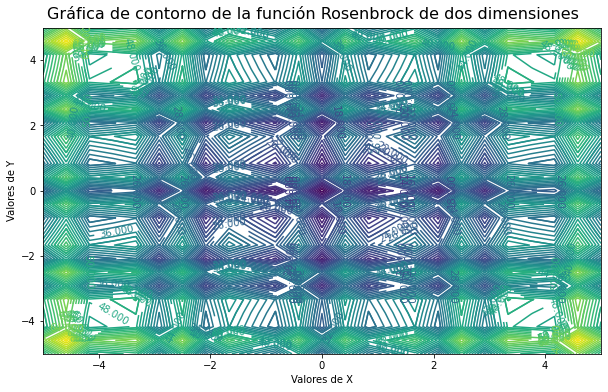

In [74]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

x = y = np.linspace(-5, 5, 25)
X,Y = np.meshgrid(x,y)
Z = f_rastrigin([X,Y])
cs = ax.contour(X, Y, Z, 50) #numero de niveles del contorno
ax.clabel(cs, fontsize=10) #valores de Z

#plt.title('Gráfica de contorno de la función Ackley de dos dimensiones')
plt.figtext(.5,.9,'Gráfica de contorno de la función Rosenbrock de dos dimensiones', fontsize=16, ha='center')
plt.xlabel('Valores de X')
plt.ylabel('Valores de Y')

cs = ax.contour(X,Y,Z)
plt.show()

Text(0.5, 0.9, 'Gráfica de superficie de la función Rosenbrock de dos dimensiones')

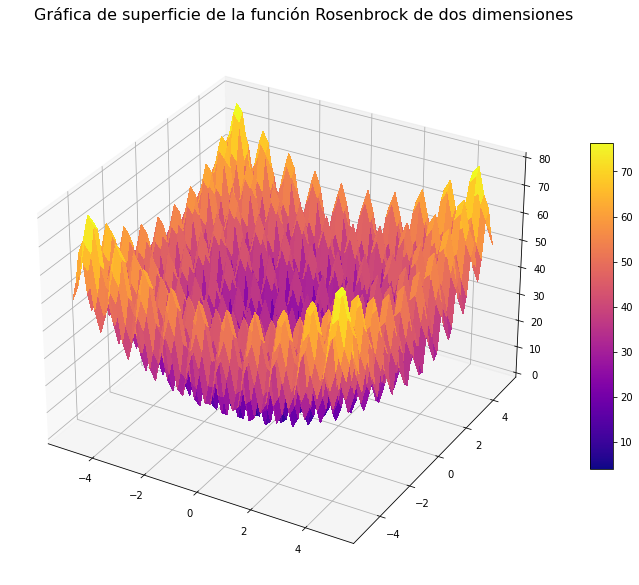

In [75]:
from matplotlib import cm

fig = plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')


x = y = np.linspace(-5, 5, 50)
X,Y = np.meshgrid(x,y)
Z = f_rastrigin([X,Y])
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 80)
fig.colorbar(surf, shrink=0.6, aspect=14)
plt.figtext(.5,.9,'Gráfica de superficie de la función Rosenbrock de dos dimensiones', fontsize=16, ha='center')

## 3.4.2 Optimización punto de borde deterministico de la función Rastrigin 

### 3.4.2.1 Optimización con nuestro algoritmo de la función Rastrigin - punto de borde deterministico - Dimensión 2 

In [76]:
RAS_X0_2 = [-5,5]
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [77]:
Rastrigin2_min, Rastrigin2_max, Rastrigin2_prom, Rastrigin2_med, Rastrigin2_datos = evaluador(fN_rastrigin, RAS_X0_2, 0.760, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rastrigin2_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rastrigin2_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rastrigin2_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rastrigin2_med}"))
Rastrigin2_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 200.98203803699238
El máximo de los minimo valor de la función en las 25 optimizaciones es: 200.98203803699238
El promedio de los minimos de la función en las 25 optimizaciones es: 200.98203803699235
La mediana del minimo del valor de la función en las 25 optimizaciones es: 200.98203803699238


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
1,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
2,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
3,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
4,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
5,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
6,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
7,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
8,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"
9,0.76,46,0.00295,200.982038,"[10.93835563439377, 8.948994880797317]"


### 3.4.2..2 Optimización con nuestro algoritmo dela función Rastrigin - punto de borde deterministico  - Dimensión 5

In [78]:
RAS_X0_5 = [-5,5, 5, 5, 5]
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [79]:
Rastrigin5_min, Rastrigin5_max, Rastrigin5_prom, Rastrigin5_med, Rastrigin5_datos = evaluador(fN_rastrigin, RAS_X0_5, 0.760, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rastrigin5_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rastrigin5_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rastrigin5_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rastrigin5_med}"))
Rastrigin5_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 909.4632118323765
El máximo de los minimo valor de la función en las 25 optimizaciones es: 909.4632118323765
El promedio de los minimos de la función en las 25 optimizaciones es: 909.4632118323764
La mediana del minimo del valor de la función en las 25 optimizaciones es: 909.4632118323765


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
1,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
2,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
3,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
4,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
5,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
6,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
7,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
8,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"
9,0.76,131,0.002899,909.463212,"[9.54416256528681, 5.523153327728189, 14.571812525197203, 3.5128600863520716, -21.625827225096664]"


### 3.4.2.3 Optimización con nuestro algoritmo de la función Rastrigin - punto de borde deterministico  - Dimensión 10

In [80]:
RAS_X0_10 = [-5,5, 5, 5, 5, 5, 5, 5, 5, 5]
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [81]:
Rastrigin10_min, Rastrigin10_max, Rastrigin10_prom, Rastrigin10_med, Rastrigin10_datos = evaluador(fN_rastrigin, RAS_X0_10, 0.760, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rastrigin10_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rastrigin10_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rastrigin10_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rastrigin10_med}"))
Rastrigin10_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 1102.345656165593
El máximo de los minimo valor de la función en las 25 optimizaciones es: 1102.345656165593
El promedio de los minimos de la función en las 25 optimizaciones es: 1102.345656165593
La mediana del minimo del valor de la función en las 25 optimizaciones es: 1102.345656165593


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
1,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
2,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
3,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
4,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
5,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
6,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
7,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
8,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"
9,0.76,1914,0.003083,1102.345656,"[10.938360673798172, -13.931891385141032, -19.895853224050416, -3.9847799248708684, 1.9849096452386448, 4.969685128278952, 4.96968664151467, -9.953709844916347, 10.938366137731157, 9.943705295673029]"


## 3.4.3  Caso con puntos de inicio aleatorios de la función Rastrigin

### 3.4.3.1 Optimización con nuestro algoritmo de la función Rastrigin - puntos de inicio aleatorios - Dimensión 2

In [82]:
RAS_X0_2A = np.random.uniform(low=-5, high=5, size=2)
RAS_X0_2A

array([ 1.78835533, -2.88371884])

In [83]:
Rastrigin2A_min, Rastrigin2A_max, Rastrigin2A_prom, Rastrigin2A_med, Rastrigin2A_datos = evaluador(fN_rastrigin, RAS_X0_2A, 0.760, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rastrigin2A_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rastrigin2A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rastrigin2A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rastrigin2A_med}"))
Rastrigin2A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 245.5422633756854
El máximo de los minimo valor de la función en las 25 optimizaciones es: 245.5422633756854
El promedio de los minimos de la función en las 25 optimizaciones es: 245.5422633756854
La mediana del minimo del valor de la función en las 25 optimizaciones es: 245.5422633756854


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
1,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
2,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
3,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
4,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
5,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
6,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
7,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
8,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"
9,0.76,50,0.004659,245.542263,"[11.554974400499162, -8.54885211023534]"


### 3.4.3.2 Optimización con nuestro algoritmo de la función Rastrigin - puntos de inicio aleatorios - Dimensión 5

In [84]:
RAS_X0_5A = np.random.uniform(low=-5, high=5, size=5)
RAS_X0_5A    

array([-2.34453341, -0.08426841, -4.46637455,  0.74117605, -3.53271425])

In [85]:
Rastrigin5A_min, Rastrigin5A_max, Rastrigin5A_prom, Rastrigin5A_med, Rastrigin5A_datos = evaluador(fN_rastrigin, RAS_X0_5A, 0.760, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rastrigin5A_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rastrigin5A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rastrigin5A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rastrigin5A_med}"))
Rastrigin5A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 487.49968385787565
El máximo de los minimo valor de la función en las 25 optimizaciones es: 487.49968385787565
El promedio de los minimos de la función en las 25 optimizaciones es: 487.49968385787565
La mediana del minimo del valor de la función en las 25 optimizaciones es: 487.49968385787565


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
1,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
2,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
3,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
4,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
5,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
6,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
7,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
8,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"
9,0.76,325,0.007204,487.499684,"[-4.979683013990001, 17.898461887078586, 3.9747799513855995, 9.943715531083644, 4.969675738505446]"


### 3.4.3.3 Optimización con nuestro algoritmo de la función Rastrigin - puntos de inicio aleatorios - Dimensión 10

In [86]:
RAS_X0_10A = np.random.uniform(low=-5, high=5, size=10)
RAS_X0_10A

array([ 0.89305537,  1.9975836 , -3.97665571, -0.85944012,  1.94400158,
       -0.8582073 , -4.50046541,  0.35896406,  1.63794645,  0.14889112])

In [87]:
Rastrigin10A_min, Rastrigin10A_max, Rastrigin10A_prom, Rastrigin10A_med, Rastrigin10A_datos = evaluador(fN_rastrigin, RAS_X0_10A, 0.760, 25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rastrigin10A_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rastrigin10A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rastrigin10A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rastrigin10A_med}"))
Rastrigin10A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 1153.061714046846
El máximo de los minimo valor de la función en las 25 optimizaciones es: 1153.061714046846
El promedio de los minimos de la función en las 25 optimizaciones es: 1153.061714046846
La mediana del minimo del valor de la función en las 25 optimizaciones es: 1153.061714046846


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
1,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
2,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
3,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
4,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
5,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
6,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
7,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
8,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"
9,0.76,1950,0.007104,1153.061714,"[18.892246660190832, -8.958996156318015, 12.92746665500997, -6.9694146577433465, -0.005004615670020307, -3.9847715327893485, 6.959415006530488, 2.979850432442838, -7.9642196991761685, 18.89226289884376]"


## 3.5 Función Rosenbrock


Función tomada de la página [www.sfu.ca](https://www.sfu.ca/~ssurjano/rosen.html)

<img src="https://www.sfu.ca/~ssurjano/rosen.png">
<img src="https://www.sfu.ca/~ssurjano/rosen2.png">

Es una función continua semiconvexa y usualmente se evalua en el hipercubo $x_i$ ∈ $[-5, 10]$, para todo i = 1, …, d, sin embargo este puede restringirse al hipercubo $x_i$ ∈ $[-2.048, 2.048]$, para todo i = 1, …, d. 


La función Rosenbrock tiene el mínimo global en el punto $f(x^*) = 0$ en $x^* \epsilon [1,...,1]$

## 3.5.1 Programación de la función Rosenbrock

### 3.5.1.1 Función Rosenbrock caso 2 dimensiones expandidas manualmente

In [88]:
#Definición de la función Ackley
def f_rosen(x):
    """
    x es un array
    """
    return 100 * np.power(x[1] - np.power(x[0],2),2) +np.power(x[0]-1,2)

In [89]:
#ejemplo de evaluacion de la funcion esfera en 2 dimensiones en el punto (1,1)
print (f_rosen([1,1]))

0


### 3.5.1.2  Función Rosenbrock caso de N dimensiones

In [90]:
def fN_rosen(x):
    """
    x es un array
    """
    #print(x)
    x = np.array(x)    
    funcion = np.sum(100.0 * np.power(x[1:] - np.power(x[:-1],2),2) + np.power((1-x[:-1]),2))
    
    return funcion  

In [91]:
print (fN_rosen([1,1]))

0.0


Se observa que el resultado para el caso N=2 es igual a la implementación para 2 dimensiones. A continuación se realizan las gráficas de contorno y de la función

### 3.5.1.3 Gráfica de contorno de la función Rosenbrock de dos variables en un plano cartesiano y en tres dimensiones

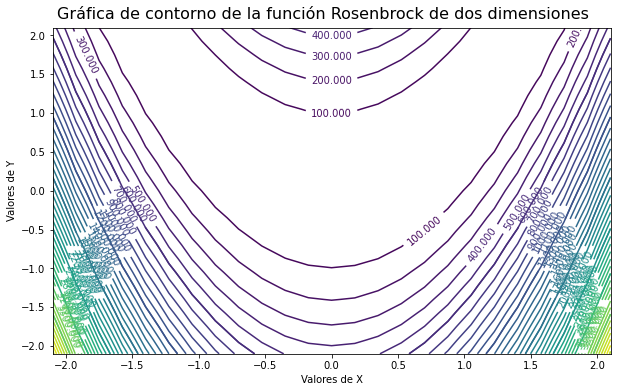

In [92]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

x = y = np.linspace(-2.1, 2.1, 25)
X,Y = np.meshgrid(x,y)
Z = f_rosen([X,Y])
cs = ax.contour(X, Y, Z, 50) #numero de niveles del contorno
ax.clabel(cs, fontsize=10) #valores de Z

#plt.title('Gráfica de contorno de la función Ackley de dos dimensiones')
plt.figtext(.5,.9,'Gráfica de contorno de la función Rosenbrock de dos dimensiones', fontsize=16, ha='center')
plt.xlabel('Valores de X')
plt.ylabel('Valores de Y')

cs = ax.contour(X,Y,Z)
plt.show()

Text(0.5, 0.9, 'Gráfica de superficie de la función Rosenbrock de dos dimensiones')

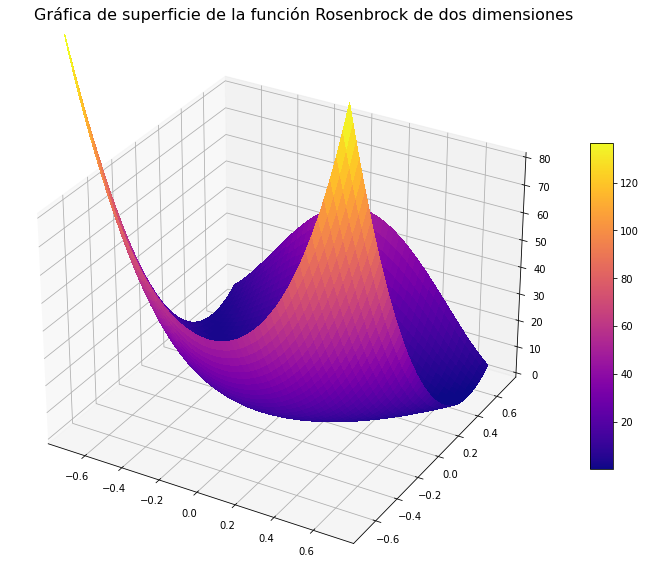

In [93]:
from matplotlib import cm

fig = plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')


x = y = np.linspace(-0.7, 0.7, 50)
X,Y = np.meshgrid(x,y)
Z = f_rosen([X,Y])
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 80)
fig.colorbar(surf, shrink=0.6, aspect=14)
plt.figtext(.5,.9,'Gráfica de superficie de la función Rosenbrock de dos dimensiones', fontsize=16, ha='center')

## 3.5.2 Optimización punto de borde deterministico de la función Rosenbrock

### 3.5.2.1 Optimización con nuestro algoritmo de la función Rosenbrock - punto de borde deterministico - Dimensión 2 

In [94]:
ROS_X0_2 = [-1.5,1.5]
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [95]:
Rosenbrock2_min, Rosenbrock2_max, Rosenbrock2_prom, Rosenbrock2_med, Rosenbrock2_datos = evaluador(fN_rosen, ROS_X0_2, 0.762,25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rosenbrock2_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rosenbrock2_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rosenbrock2_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rosenbrock2_med}"))
Rosenbrock2_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 0.41046143779400873
El máximo de los minimo valor de la función en las 25 optimizaciones es: 0.41046143779400873
El promedio de los minimos de la función en las 25 optimizaciones es: 0.41046143779400873
La mediana del minimo del valor de la función en las 25 optimizaciones es: 0.41046143779400873


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
1,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
2,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
3,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
4,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
5,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
6,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
7,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
8,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"
9,0.762,222,0.001413,0.410461,"[0.3612780705141408, 0.12552611146747852]"


### 3.5.2..2 Optimización con nuestro algoritmo dela función Rosenbrock - punto de borde deterministico  - Dimensión 5

In [96]:
ROS_X0_5 = [-1.51,1.51, 1.51, 1.51, 1.51]
#var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [97]:
Rosenbrock5_min, Rosenbrock5_max, Rosenbrock5_prom, Rosenbrock5_med, Rosenbrock5_datos = evaluador(fN_rosen, ROS_X0_5, 0.762,25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rosenbrock5_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rosenbrock5_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rosenbrock5_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rosenbrock5_med}"))
Rosenbrock5_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 3.031090046839778e+123
El máximo de los minimo valor de la función en las 25 optimizaciones es: 3.031090046839778e+123
El promedio de los minimos de la función en las 25 optimizaciones es: 3.031090046839778e+123
La mediana del minimo del valor de la función en las 25 optimizaciones es: 3.031090046839778e+123


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
1,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
2,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
3,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
4,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
5,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
6,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
7,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
8,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"
9,0.762,5,0.0,3.031090e+123,"[-2.7081916481034818e+29, -1.7211716144363715e+29, 2.34626626046166e+30, 1354835379939440.2, 6.121882821227582e+28]"


### 3.5.2.3 Optimización con nuestro algoritmo de la función Rosenbrock - punto de borde deterministico  - Dimensión 10

In [98]:
ROS_X0_10 = [-1.5,1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
var_sensibilidad  = np.around(np.linspace(0.01, 1.3, num=25, endpoint=True), decimals=3).tolist()

In [99]:
Rosenbrock10_min, Rosenbrock10_max, Rosenbrock10_prom, Rosenbrock10_med, Rosenbrock10_datos = evaluador(fN_rosen, ROS_X0_10, 0.762,25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rosenbrock10_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rosenbrock10_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rosenbrock10_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rosenbrock10_med}"))
Rosenbrock10_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 7.43520137247315e+111
El máximo de los minimo valor de la función en las 25 optimizaciones es: 7.43520137247315e+111
El promedio de los minimos de la función en las 25 optimizaciones es: 7.435201372473151e+111
La mediana del minimo del valor de la función en las 25 optimizaciones es: 7.43520137247315e+111


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
1,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
2,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
3,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
4,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
5,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
6,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
7,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
8,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"
9,0.762,5,0.0,7.435201e+111,"[8.078936931771478e+26, 1.6093389760324755e+27, -1.9621591407837257e+27, -7.664396268225628e+26, -1.319160511550377e+27, -2.2348347772494296e+27, 1.7337011750962276e+27, -1.6821138925216346e+27, -1.628684206997949e+27, 7.276052271612176e+25]"


## 3.5.3  Caso con puntos de inicio aleatorios de la función Rosenbrock

### 3.5.3.1 Optimización con nuestro algoritmo de la función Rosenbrock - puntos de inicio aleatorios - Dimensión 2

In [100]:
ROS_X0_2A = np.random.uniform(low=--2, high=2, size=2)
ROS_X0_2A

array([2., 2.])

In [101]:
Rosenbrock2A_min, Rosenbrock2A_max, Rosenbrock2A_prom, Rosenbrock2A_med, Rosenbrock2A_datos = evaluador(fN_rosen, ROS_X0_2A,  1.088,25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rosenbrock2A_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rosenbrock2A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rosenbrock2A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rosenbrock2A_med}"))
Rosenbrock2A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 0.41079174206042574
El máximo de los minimo valor de la función en las 25 optimizaciones es: 0.41079174206042574
El promedio de los minimos de la función en las 25 optimizaciones es: 0.41079174206042574
La mediana del minimo del valor de la función en las 25 optimizaciones es: 0.41079174206042574


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
1,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
2,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
3,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
4,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
5,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
6,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
7,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
8,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"
9,1.088,168,0.001957,0.410792,"[0.3610168337175444, 0.12534090496676378]"


### 3.5.3.2 Optimización con nuestro algoritmo de la función Rosenbrock - puntos de inicio aleatorios - Dimensión 5

In [102]:
ROS_X0_5A = np.random.uniform(low=-2, high=2, size=5)
ROS_X0_5A

array([ 1.61360766, -1.45010118, -1.44289461,  1.22956515, -0.40929265])

In [103]:
Rosenbrock5A_min, Rosenbrock5A_max, Rosenbrock5A_prom, Rosenbrock5A_med, Rosenbrock5A_datos = evaluador(fN_rosen, ROS_X0_5A, 1.088,25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rosenbrock5A_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rosenbrock5A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rosenbrock5A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rosenbrock5A_med}"))
Rosenbrock5A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 4.35692946563127e+87
El máximo de los minimo valor de la función en las 25 optimizaciones es: 4.35692946563127e+87
El promedio de los minimos de la función en las 25 optimizaciones es: 4.35692946563127e+87
La mediana del minimo del valor de la función en las 25 optimizaciones es: 4.35692946563127e+87


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
1,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
2,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
3,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
4,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
5,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
6,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
7,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
8,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"
9,1.088,4,0.0,4.356929e+87,"[-2.4084069058767752e+20, -1.6056046036731304e+20, -3.211209213878402e+20, -2.5689673664303485e+21, 2.007005753566487e+19]"


### 3.5.3.3 Optimización con nuestro algoritmo de la función Rosenbrock - puntos de inicio aleatorios - Dimensión 10

In [104]:
ROS_X0_10A = np.random.uniform(low=-2, high=2, size=10)
ROS_X0_10A

array([-1.33858321,  1.71003432, -0.60893656,  1.00324841,  0.90399194,
        1.53322436,  0.49468883,  1.00376974, -0.60440663, -0.92028843])

In [105]:
Rosenbrock10A_min, Rosenbrock10A_max, Rosenbrock10A_prom, Rosenbrock10A_med, Rosenbrock10A_datos = evaluador(fN_rosen, ROS_X0_10A, 1.088,25)
print (f"El minimo de los minimo valor de la función en las 25 optimizaciones es: {Rosenbrock10A_min}")
print ("El máximo de los minimo valor de la función en las 25 optimizaciones es: {}".format(Rosenbrock10A_max))
print ("El promedio de los minimos de la función en las 25 optimizaciones es: " + str(Rosenbrock10A_prom))
print ((f"La mediana del minimo del valor de la función en las 25 optimizaciones es: {Rosenbrock10A_med}"))
Rosenbrock10A_datos

El minimo de los minimo valor de la función en las 25 optimizaciones es: 5.2126874867586504e+88
El máximo de los minimo valor de la función en las 25 optimizaciones es: 5.2126874867586504e+88
El promedio de los minimos de la función en las 25 optimizaciones es: 5.2126874867586504e+88
La mediana del minimo del valor de la función en las 25 optimizaciones es: 5.2126874867586504e+88


,Paso,Iteraciones para convergencia,gradiente en el minimo,F(X) en el minimo,Coordenadas
0,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
1,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
2,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
3,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
4,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
5,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
6,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
7,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
8,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"
9,1.088,4,0.0,5.212687e+88,"[-7.526271582752794e+19, -4.0140115147396465e+19, -2.5689673669217385e+21, 2.0070057555552453e+20, -6.021017266322385e+20, 1.6056046128912872e+20, -2.2478464460590544e+21, -4.4956928911910424e+21, -2.5689673669938653e+21, -6.422418417120679e+20]"


## 3.6 Resumen de resultados 

### 3.6.1 Resumen de resultados para 2 dimensiones con punto de inicio deterministico

In [106]:
dim_2_dict= {
    "Variables" : ["Punto de Inicio", "Mín", "Max","Promedio", "Med"],
    "Ackley": [ACK_X0_2, Ackley2_min,Ackley2_max,Ackley2_prom,Ackley2_med],
    "Esfera" : [ESF_X0_2, Esfera2_min,Esfera2_max,Esfera2_prom,Esfera2_med],
    "Griewank": [GRI_X0_2, Griewank2_min,Griewank2_max,Griewank2_prom,Griewank2_med],
    "Rastrigin": [RAS_X0_2, Rastrigin2_min,Rastrigin2_max,Rastrigin2_prom,Rastrigin2_med],
    "Rosenbrock": [ROS_X0_2, Rosenbrock2_min,Rosenbrock2_max,Rosenbrock2_prom,Rosenbrock2_med]}

resumen_2_df = pd.DataFrame(dim_2_dict).set_index(["Variables"])
resumen_2_df

,Ackley,Esfera,Griewank,Rastrigin,Rosenbrock
Variables,,,,,
Punto de Inicio,"[16.0, 16]","[5.0, 5]","[100.0, 100]","[-5, 5]","[-1.5, 1.5]"
Mín,20.0039,5e-05,6.0015,200.982,0.410461
Max,20.0039,5e-05,6.0015,200.982,0.410461
Promedio,20.0039,5e-05,6.0015,200.982,0.410461
Med,20.0039,5e-05,6.0015,200.982,0.410461


### 3.6.2 Resumen de resultados para 5 dimensiones con punto de inicio deterministico

In [107]:
dim_5_dict= {
    "Variables" : ["Punto de Inicio", "Mín", "Max","Promedio", "Med"],
    "Ackley": [ACK_X0_5, Ackley5_min,Ackley5_max,Ackley5_prom,Ackley5_med],
    "Esfera" : [ESF_X0_5, Esfera5_min,Esfera5_max,Esfera5_prom,Esfera5_med],
    "Griewank": [GRI_X0_5, Griewank5_min,Griewank5_max,Griewank5_prom,Griewank5_med],
    "Rastrigin": [RAS_X0_5, Rastrigin5_min,Rastrigin5_max,Rastrigin5_prom,Rastrigin5_med],
    "Rosenbrock": [ROS_X0_5, Rosenbrock5_min,Rosenbrock5_max,Rosenbrock5_prom,Rosenbrock5_med]}

resumen_5_df = pd.DataFrame(dim_5_dict).set_index(["Variables"])
resumen_5_df

,Ackley,Esfera,Griewank,Rastrigin,Rosenbrock
Variables,,,,,
Punto de Inicio,"[-12.0, 12, -12, 12, -12]","[5.0, 5.0, 5.0, 5.0, 5.0]","[100.0, 100.0, 100.0, 100.0, 100.0]","[-5, 5, 5, 5, 5]","[-1.51, 1.51, 1.51, 1.51, 1.51]"
Mín,22.2328,0.000125,5.03016,909.463,3.03109e+123
Max,22.2328,0.000125,5.03016,909.463,3.03109e+123
Promedio,22.2328,0.000125,5.03016,909.463,3.03109e+123
Med,22.2328,0.000125,5.03016,909.463,3.03109e+123


### 3.6.3 Resumen de resultados para 10 dimensiones con punto de inicio deterministico

In [108]:
dim_10_dict= {
    "Variables" : ["Punto de Inicio", "Mín", "Max","Promedio", "Med"],
    "Ackley": [ACK_X0_10, Ackley10_min,Ackley10_max,Ackley10_prom,Ackley10_med],
    "Esfera" : [ESF_X0_10, Esfera10_min,Esfera10_max,Esfera10_prom,Esfera10_med],
    "Griewank": [GRI_X0_10, Griewank10_min,Griewank10_max,Griewank10_prom,Griewank10_med],
    "Rastrigin": [RAS_X0_10, Rastrigin10_min,Rastrigin10_max,Rastrigin10_prom,Rastrigin10_med],
    "Rosenbrock": [ROS_X0_10, Rosenbrock10_min,Rosenbrock10_max,Rosenbrock10_prom,Rosenbrock10_med]}

resumen_10_df = pd.DataFrame(dim_10_dict).set_index(["Variables"])
resumen_10_df

,Ackley,Esfera,Griewank,Rastrigin,Rosenbrock
Variables,,,,,
Punto de Inicio,"[-12.0, 12, -12, 12, -12, 16, -12, 12, -12, 9]","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]","[-5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[-1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]"
Mín,21.8772,0.00025,24.6241,1102.35,7.4352e+111
Max,21.8772,0.00025,24.6241,1102.35,7.4352e+111
Promedio,21.8772,0.00025,24.6241,1102.35,7.4352e+111
Med,21.8772,0.00025,24.6241,1102.35,7.4352e+111


### 3.6.4 Resumen de resultados para 2 dimensiones con punto de inicio aleatorio

In [109]:
dim_2_A_dict= {
    "Variables" : ["Punto de Inicio", "Mín", "Max","Promedio", "Med"],
    "Ackley": [ACK_X0_2A, Ackley2A_min,Ackley2A_max,Ackley2A_prom,Ackley2A_med],
    "Esfera" : [ESF_X0_2A, Esfera2A_min,Esfera2A_max,Esfera2A_prom,Esfera2A_med],
    "Griewank": [GRI_X0_2A, Griewank2A_min,Griewank2A_max,Griewank2A_prom,Griewank2A_med],
    "Rastrigin": [RAS_X0_2A, Rastrigin2A_min,Rastrigin2A_max,Rastrigin2A_prom,Rastrigin2A_med],
    "Rosenbrock": [ROS_X0_2A, Rosenbrock2A_min,Rosenbrock2A_max,Rosenbrock2A_prom,Rosenbrock2A_med]}

resumen_2A_df = pd.DataFrame(dim_2_A_dict).set_index(["Variables"])
resumen_2A_df

,Ackley,Esfera,Griewank,Rastrigin,Rosenbrock
Variables,,,,,
Punto de Inicio,"[-2.655295849517632, 7.050383790149059]","[0.5868982844575168, -3.596130614047662]","[38.37542279009466, -36.89687379878741]","[1.7883553293989092, -2.8837188399994096]","[2.0, 2.0]"
Mín,22.2674,5e-05,1.72365,245.542,0.410792
Max,22.2674,5e-05,1.72365,245.542,0.410792
Promedio,22.2674,5e-05,1.72365,245.542,0.410792
Med,22.2674,5e-05,1.72365,245.542,0.410792


### 3.6.5 Resumen de resultados para 5 dimensiones con punto de inicio aleatorio

In [110]:
dim_5_A_dict= {
    "Variables" : ["Punto de Inicio", "Mín", "Max","Promedio", "Med"],
    "Ackley": [ACK_X0_5A, Ackley5A_min,Ackley5A_max,Ackley5A_prom,Ackley5A_med],
    "Esfera" : [ESF_X0_5A, Esfera5A_min,Esfera5A_max,Esfera5A_prom,Esfera5A_med],
    "Griewank": [GRI_X0_5A, Griewank5A_min,Griewank5A_max,Griewank5A_prom,Griewank5A_med],
    "Rastrigin": [RAS_X0_5A, Rastrigin5A_min,Rastrigin5A_max,Rastrigin5A_prom,Rastrigin5A_med],
    "Rosenbrock": [ROS_X0_5A, Rosenbrock5A_min,Rosenbrock5A_max,Rosenbrock5A_prom,Rosenbrock5A_med]}

resumen_5A_df = pd.DataFrame(dim_5_A_dict).set_index(["Variables"])
resumen_5A_df

,Ackley,Esfera,Griewank,Rastrigin,Rosenbrock
Variables,,,,,
Punto de Inicio,"[-15.996340005844964, -6.325357675781127, -11.303811493852383, -13.04516496739847, -10.039673235914531]","[-3.0189851091512123, 3.007445686755366, 4.682615757193975, -1.8657582184075716, 1.9232261566931408]","[37.30018553631675, 66.92513437947457, -96.34234453116164, 50.028862988993495, 97.77221778129893]","[-2.344533406277738, -0.08426840719661755, -4.466374548829196, 0.7411760549201309, -3.5327142509418987]","[1.613607661151534, -1.45010118341505, -1.4428946109969658, 1.2295651548380953, -0.4092926520578657]"
Mín,21.9164,0.000125,2.06749,487.5,4.35693e+87
Max,21.9164,0.000125,2.06749,487.5,4.35693e+87
Promedio,21.9164,0.000125,2.06749,487.5,4.35693e+87
Med,21.9164,0.000125,2.06749,487.5,4.35693e+87


### 3.6.6 Resumen de resultados para 10 dimensiones con punto de inicio aleatorio

In [111]:
dim_10_A_dict= {
    "Variables" : ["Punto de Inicio", "Mín", "Max","Promedio", "Med"],
    "Ackley": [ACK_X0_10A, Ackley10A_min,Ackley10A_max,Ackley10A_prom,Ackley10A_med],
    "Esfera" : [ESF_X0_10A, Esfera10A_min,Esfera10A_max,Esfera10A_prom,Esfera10A_med],
    "Griewank": [GRI_X0_10A, Griewank10A_min,Griewank10A_max,Griewank10A_prom,Griewank10A_med],
    "Rastrigin": [RAS_X0_10A, Rastrigin10A_min,Rastrigin10A_max,Rastrigin10A_prom,Rastrigin10A_med],
    "Rosenbrock": [ROS_X0_10A, Rosenbrock10A_min,Rosenbrock10A_max,Rosenbrock10A_prom,Rosenbrock10A_med]}

resumen_10A_df = pd.DataFrame(dim_10_A_dict).set_index(["Variables"])
resumen_10A_df

,Ackley,Esfera,Griewank,Rastrigin,Rosenbrock
Variables,,,,,
Punto de Inicio,"[-4.942056734622472, -3.303440824618562, 1.2421354881074222, -2.5857755390945663, 5.927024012696304, -9.457528008591442, 12.099757964510253, -15.123597017666363, 5.454960325708871, -2.646246324251937]","[3.7638915229603835, 3.9460666350384734, -4.149557886302221, -4.609452167671177, -3.3016958043543108, 3.7814250342941307, -4.016531661669499, -0.7889237499494781, 4.578895301505019, 0.33165284973017073]","[49.63313087596788, -43.91120158711897, 57.85586569029769, -79.3547986844716, -10.421294764818967, 81.71910061861911, -41.2771703252641, -42.44493228273025, -73.99428557634447, -96.12660842594059]","[0.893055369032842, 1.9975836002093121, -3.9766557117217416, -0.8594401218043171, 1.9440015772774508, -0.8582073047309731, -4.500465410539128, 0.35896405915511576, 1.6379464521978884, 0.14889112058308562]","[-1.338583211532269, 1.7100343215841356, -0.6089365610179738, 1.0032484125446222, 0.9039919414018058, 1.5332243648232393, 0.49468882822243554, 1.0037697361093487, -0.6044066320886299, -0.9202884329398957]"
Mín,21.9223,0.00025,1.07727,1153.06,5.21269e+88
Max,21.9223,0.00025,1.07727,1153.06,5.21269e+88
Promedio,21.9223,0.00025,1.07727,1153.06,5.21269e+88
Med,21.9223,0.00025,1.07727,1153.06,5.21269e+88


### BIBLIOGRAFIA

- Chandra Suresh, Jayadera y Mehra Aparna.  Numerical Optimization with Applications.  Narosa Publishing House.  2009.  Segunda Edicion.
- Nocedal Jorge y Wright Stephen.  Numerical Optimization.  Springer.  2006.  Segunda Edicion.
- Butenko Sergiy y Pardalos Panos.  Numerical Methods and Optimizations an Introduction.  Chapman & Hall.  2014.
- Gramfort Alexandre.  (Quasi-)Newton methods.    online: http://www.lix.polytechnique.fr/bigdata/mathbigdata/wp-content/uploads/2014/09/notes_quasi_newton.pdf
